# Исследование мобильной игры


## Описание проекта

Проект сосредоточен на анализе мобильной игры с целью улучшения игровых и бизнес-показателей. В рамках проекта были решены три ключевые задачи:

- Анализ удержания игроков: Оценка удержания пользователей по дням с момента регистрации, чтобы выявить тенденции и пиковые периоды активности.

- A/B тестирование акционных предложений: Сравнение двух групп пользователей для определения более эффективного набора акционных предложений, используя метрики ARPU, CR и ARPPU.

- Оценка тематического события: Анализ результатов тематического события, включая оценку вовлеченности, уровня завершения и влияния на доход, а также адаптация метрик для оценки изменений в механике событий.

## Импорт необходимых библиотек

In [82]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt

import requests
from urllib.parse import urlencode

import scipy.stats as ss
import pingouin as pg

# Задание 1

## Проведение EDA

Retention – один из самых важных показателей в компании. 
Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока)

In [83]:
# Загрузка данных
regist_time = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')
auth_time = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')

In [84]:
# Данные о времени регистрации
regist_time.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [85]:
# Данные о времени захода пользователей в игру 
auth_time.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [86]:
regist_time.nunique()

reg_ts    1000000
uid       1000000
dtype: int64

In [87]:
auth_time.nunique()

auth_ts    9180915
uid        1000000
dtype: int64

In [88]:
regist_time.duplicated().sum()

0

In [89]:
auth_time.duplicated().sum()

0

Значений-дубликатов не наблюдается ни в одной из таблиц. 

In [90]:
regist_time.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [91]:
auth_time.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype
---  ------   --------------    -----
 0   auth_ts  9601013 non-null  int64
 1   uid      9601013 non-null  int64
dtypes: int64(2)
memory usage: 146.5 MB


Пустых значений не наблюдается ни в одной из таблиц. Тип данных - целочисленный.

In [92]:
regist_time.describe()

,reg_ts,uid
count,1.000000e+06,1.000000e+06
mean,1.548332e+09,5.552354e+05
std,5.253653e+07,3.206011e+05
min,9.113822e+08,1.000000e+00
25%,1.528034e+09,2.776438e+05
50%,1.564454e+09,5.550455e+05
75%,1.585759e+09,8.329712e+05
max,1.600874e+09,1.110622e+06


In [93]:
auth_time.describe()

,auth_ts,uid
count,9.601013e+06,9.601013e+06
mean,1.548778e+09,3.347198e+05
std,5.160527e+07,2.832669e+05
min,9.113822e+08,1.000000e+00
25%,1.528375e+09,9.599700e+04
50%,1.564577e+09,2.579210e+05
75%,1.585823e+09,5.190250e+05
max,1.600874e+09,1.110622e+06


Данные в таблицах `regist_time` и `auth_time` выглядят согласованными. Временные метки и диапазоны `ts` совпадают, что подтверждает целостность данных. Основное отличие заключается в том, что количество записей в `auth_time` значительно больше, что ожидаемо из-за многократных авторизаций пользователей. В целом, данные можно считать надежными и корректными.

## Вычисление показателя retention

In [94]:
# Объединим наборы данных в один датафрейм
df = regist_time.merge(auth_time, how='outer', on='uid')

In [95]:
# Преобразуем время к более удобному для восприятия отображению дат
df['reg_ts'] = pd.to_datetime(df.reg_ts, unit='s').dt.date
df['auth_ts'] = pd.to_datetime(df.auth_ts, unit='s').dt.date

In [96]:
df.reg_ts = pd.to_datetime(df['reg_ts'])
df.auth_ts = pd.to_datetime(df['auth_ts'])

In [97]:
df.dtypes

reg_ts     datetime64[ns]
uid                 int64
auth_ts    datetime64[ns]
dtype: object

In [98]:
# Для удобства вынесу id как первую колонку
df = df[['uid', 'reg_ts', 'auth_ts']]

In [99]:
df.head()

,uid,reg_ts,auth_ts
0,1,1998-11-18,1998-11-18
1,2,1999-07-22,1999-07-22
2,2,1999-07-22,1999-07-25
3,2,1999-07-22,1999-07-31
4,2,1999-07-22,1999-08-05


In [100]:
def calculate_retention(df, start_date, end_date):
    """
    Вычисляет процент удержания пользователей за определённый период.

    Параметры:
    df (DataFrame): Исходный DataFrame, содержащий данные о пользователях.
        Ожидается, что столбцы 'auth_ts' и 'reg_ts' содержат временные метки 
        (тип datetime), соответствующие времени регистрации и аутентификации.
    start_date (datetime): Начальная дата для фильтрации данных (включительно).
    end_date (datetime): Конечная дата для фильтрации данных (включительно).

    Возвращает:
    DataFrame: Таблица удержания пользователей, где строки соответствуют 
    дате регистрации, а столбцы — количеству дней, прошедших с момента регистрации.
    Значения в таблице представляют собой долю пользователей, вернувшихся 
    через определённое количество дней.

    Пример использования:
    >>> retention = calculate_retention(df, start_date, end_date)
    >>> print(retention)
    """
    
    # Вычисление разницы в днях между регистрацией и аутентификацией
    df['date_diff'] = (df.auth_ts - df.reg_ts).dt.days
    
    # Фильтрация данных по дате регистрации и аутентификации
    cohort = (
        df.query('reg_ts >= @start_date and auth_ts <= @end_date')
        .groupby(['reg_ts', 'date_diff'])
        .agg({'uid': 'nunique'})
        .reset_index()
    )
    
    # Преобразование временной метки в дату
    cohort.reg_ts = cohort.reg_ts.dt.date
    
    # Поворот таблицы для получения матрицы удержания
    retention = cohort.pivot(index='reg_ts', columns='date_diff', values='uid')
    
    # Нормализация: делим на количество пользователей, зарегистрированных в день 0 (день регистрации)
    retention = retention.div(retention[0], axis=0).round(2)
    
    # Удаление колонки с 0 днями (день регистрации), если она присутствует
    retention = retention.drop(columns=[0])
    
    return retention

In [101]:
# Преобразование строковых дат в объекты datetime
start_date = dt.strptime('2020-01-01', '%Y-%m-%d')
end_date = dt.strptime('2020-01-15', '%Y-%m-%d')

# Вызов функции calculate_retention с выбранным временным промежутком
retention = calculate_retention(df, start_date, end_date)

In [102]:
# Вывод матрицы удержания
retention

date_diff,1,2,3,4,5,6,7,8,9,10,11,12,13,14
reg_ts,,,,,,,,,,,,,,
2020-01-01,0.03,0.05,0.03,0.06,0.06,0.08,0.05,0.04,0.04,0.05,0.07,0.05,0.05,0.05
2020-01-02,0.02,0.05,0.05,0.05,0.06,0.08,0.06,0.06,0.05,0.06,0.06,0.05,0.05,NaN
2020-01-03,0.02,0.03,0.04,0.05,0.07,0.08,0.05,0.05,0.04,0.05,0.06,0.06,NaN,NaN
2020-01-04,0.01,0.04,0.05,0.05,0.06,0.07,0.05,0.04,0.05,0.05,0.05,NaN,NaN,NaN
2020-01-05,0.02,0.04,0.05,0.04,0.05,0.08,0.05,0.04,0.05,0.04,NaN,NaN,NaN,NaN
2020-01-06,0.03,0.04,0.05,0.04,0.05,0.07,0.06,0.05,0.05,NaN,NaN,NaN,NaN,NaN
2020-01-07,0.02,0.05,0.04,0.06,0.05,0.08,0.05,0.06,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,0.02,0.04,0.04,0.05,0.05,0.08,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-09,0.02,0.04,0.05,0.04,0.06,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


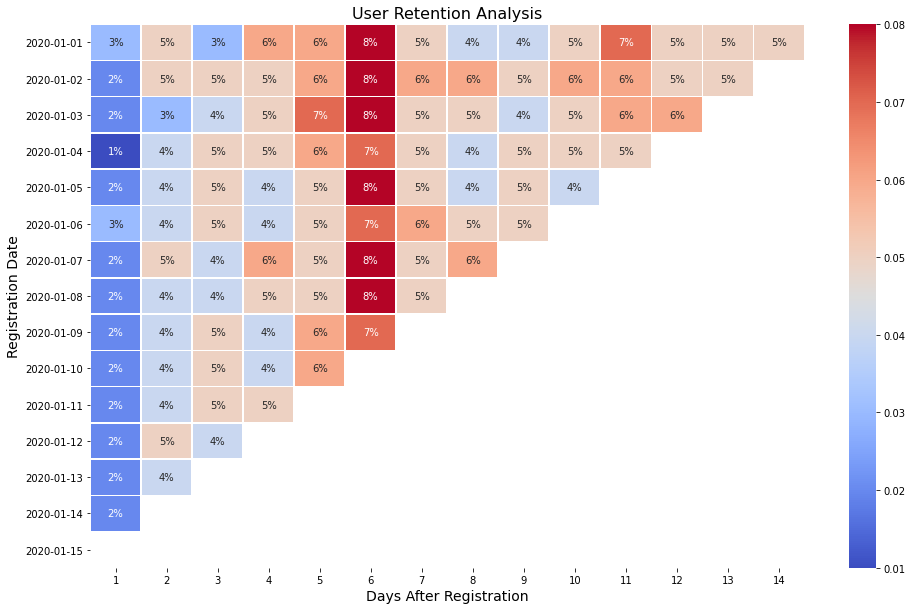

In [103]:
# Функция для визуализации
def plot_retention_heatmap(retention):
    plt.figure(figsize=(16, 10))    
    sns.heatmap(retention, annot=True, cmap='coolwarm', cbar=True, linewidths=.5, fmt='.0%')   
    plt.title('User Retention Analysis', fontsize=16)
    plt.xlabel('Days After Registration', fontsize=14)
    plt.ylabel('Registration Date', fontsize=14)      
    plt.show()
    
plot_retention_heatmap(retention)

## Вывод

#### Пик на 6-7 день

Удержание достигает пика (8%) на 6 день. Это может указывать на то, что пользователи имеют привычку возвращаться на платформу через неделю после регистрации или, возможно, в этот период проводится какая-то активность (например, рассылка, напоминание или акция), которая стимулирует возвращение пользователей.

#### Низкое удержание в начале

Первый день показывает низкое удержание (1-3%), указывая на потерю интереса или пользователи испытывают сложности с использованием платформы сразу после регистрации.
.

#### Стабильность

После пика удержание стабилизируется на уровне 4-5%.

#### Рекомендации
- Улучшить опыт в первые дни.
- Использовать пиковую активность на 6-7 день для маркетинга.
- Анализировать факторы долгосрочного удержания.

# Задание 2


Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [104]:
def url_ydisk(url):    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = url
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url    

## Проведение EDA

In [105]:
# Загрузка данных
campaign = pd.read_csv(url_ydisk('https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'), sep=';')

In [106]:
campaign.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [107]:
# Количество уникальных пользователей в контрольной группе
campaign[campaign['testgroup'] == 'a'] \
    .user_id.nunique()

202103

In [108]:
# Количество уникальных пользователей в тестовой группе
campaign[campaign['testgroup'] == 'b'] \
    .user_id.nunique()

202667

In [109]:
campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


Пустых значений в таблице не наблюдается. Тип данных преобразовывать не требуется.

In [110]:
campaign['revenue'].describe()

count    404770.000000
mean         26.083435
std         681.652928
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [111]:
campaign[['user_id', 'testgroup']].nunique()

user_id      404770
testgroup         2
dtype: int64

## Метрики

Посмотрим на следующие метрики:
- **ARPU** (Average Revenue Per User) - средний доход с привлеченного пользователя
- **CR** (Conversion Rate) - отношение числа пользователей, которые выполнили какое-либо целевое действие, к общему числу пользователей
- **ARPPU** (Average Revenue Per Paying User) - средний доход на платящего пользователя/клиента 

In [112]:
# Определим колонку под платящих и неплатящих пользователей
campaign['is_paying'] = campaign['revenue'].apply(lambda x: 1 if x > 0 else 0)

А теперь приступим к расчету метрик.

In [113]:
# Подсчёт всех пользователей в каждой группе
all_users = campaign.groupby('testgroup').size().reset_index(name='all_users')

# Подсчёт платящих пользователей в каждой группе
pay_users = campaign.groupby('testgroup')['is_paying'].sum().reset_index(name='pay_users')

# Подсчёт общего дохода в каждой группе
total_revenue = campaign.groupby('testgroup')['revenue'].sum().reset_index(name='total_revenue')

In [114]:
# Объединение результатов
result = all_users.merge(pay_users, on='testgroup').merge(total_revenue, on='testgroup')

In [115]:
# Рассчёт CR
result['CR'] = (result['pay_users'] / result['all_users']).round(4)

In [116]:
# Рассчёт ARPU 
result['ARPU'] = (result['total_revenue'] / result['all_users']).round(2)

In [117]:
# Рассчёт ARPPU 
result['ARPPU'] = (result['total_revenue'] / result['pay_users']).round(2)

In [118]:
result

,testgroup,all_users,pay_users,total_revenue,CR,ARPU,ARPPU
0,a,202103,1928,5136189,0.0095,25.41,2664.00
1,b,202667,1805,5421603,0.0089,26.75,3003.66


Проверили входные данные:
- Действительно, в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667
- ARPU и ARPPU выше в тестовой группе

## Проведение статистических тестов

## <span style="color: #8E44AD;">Гипотеза 1: CR</span>

**Тип данных:** мы имеем категориальные данные: конверсия (платящий или нет) и группы (контрольная или тестовая). **Хи-квадрат** тест подходит для анализа зависимости между двумя категориальными переменными.

**Размер выборки:** хи-квадрат тест требует, чтобы каждая ячейка в таблице сопряженности содержала достаточно наблюдений - условие соблюдено.


- $H_0$: Между тестовой и контрольной группами нет значимой разницы в конверсии. 

- $H_1$: Между тестовой и контрольной группами есть значимая разница в конверсии. 


In [119]:
# Создаем таблицу сопряженности для тестовой и контрольной групп
contingency_table = pd.crosstab(campaign.testgroup, campaign.is_paying)

In [120]:
# Проведение хи-квадрат теста
stat, p, dof, exp = ss.chi2_contingency(contingency_table)
stat, p

(4.374729521260405, 0.03647561892312613)

**Вывод:** *p-value* < 0.05 →  имеются статистически значимые основания для отклонения нулевой гипотезы.
Таким образом, существует статистически значимое различие между конверсиями групп. 

Я решила перестраховаться и посмореть на результаты теста внимательнее. *Pingouin* предлагает несколько вариаций хи-квадрат теста, что полезно для подтверждения результатов в разных условиях. Кроме того, он предоставляет дополнительные метрики, такие как *Cramér's V*, которые помогают оценить силу связи между переменными и убедиться в надежности выводов.

In [121]:
exp, obs, stats = pg.chi2_independence(data=campaign, x="testgroup", y="is_paying") 
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,4.374730,1.0,0.036476,0.003288,0.552384
1,cressie-read,0.666667,4.374870,1.0,0.036473,0.003288,0.552397
2,log-likelihood,0.000000,4.375431,1.0,0.036461,0.003288,0.552450
3,freeman-tukey,-0.500000,4.376097,1.0,0.036446,0.003288,0.552513
4,mod-log-likelihood,-1.000000,4.376973,1.0,0.036428,0.003288,0.552596
5,neyman,-2.000000,4.379356,1.0,0.036377,0.003289,0.552821


Значение *Cramér's V* ≈ 0.0364 показывает, что, несмотря на статистически значимое различие между тестовой и контрольной группами (*p-value* < 0.05), сила связи между группой тестирования и вероятностью покупки мала. 

Это может быть связано с тем, что в исследовании использовались большие выборки (по 200 тысяч наблюдений в каждой группе), что увеличивает мощность теста и позволяет обнаруживать даже небольшие различия.

## <span style="color: #8E44AD;">Гипотеза 2: ARPU</span>

In [122]:
# Датафреймы в разбивке на группы
control = campaign.query('testgroup == "a"')
test = campaign.query('testgroup == "b"')

In [123]:
# Датафреймы в разбивке на группы: только платящие пользователи
control_paying = control.query('revenue > 0')
test_paying = test.query('revenue > 0')

### Проверка дисперсий и  нормальности распределений 

In [124]:
# Подготовим массивы
control_revenue = control.revenue
test_revenue = test.revenue

Данные большие, поэтому воспользуюсь **Normaltest**.

- $H_0$: Данные распределены нормально.

- $H_1$: Данные распределены ненормально.

In [125]:
print(ss.normaltest(control_revenue))
print(ss.normaltest(test_revenue))

NormaltestResult(statistic=585152.7312728433, pvalue=0.0)
NormaltestResult(statistic=326622.39540856465, pvalue=0.0)


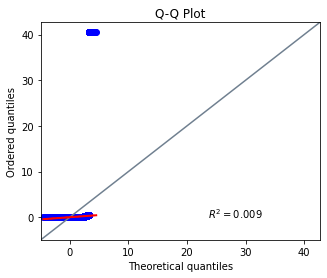

In [126]:
pg.qqplot(control_revenue)

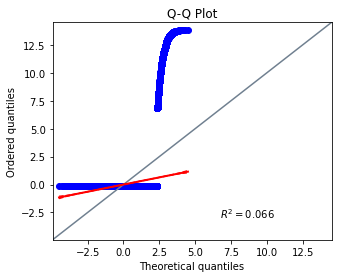

In [127]:
pg.qqplot(test_revenue)

- *p-value* < 0.05 →  имеются статистически значимые основания для отклонения нулевой гипотезы.

-  Точки на qqplot сильно отклоняются от прямой.

**Вывод**: В ходе неоднократной проверки пришли к выводу, что переменные распределены ненормально.

Также проверим распределения на гомоскедастичность с помощью теста Левена.

In [128]:
pg.homoscedasticity(data=campaign, dv="revenue", group="testgroup")

,W,pval,equal_var
levene,0.389629,0.532495,True


**Вывод**: *equal_var* равен True → дисперсии групп равны. 

Имеем право использовать **t-тест**, потому что:

- **Большие выборки:** Центральная предельная теорема (и другие предельные теоремы) делают t-тест устойчивым к нарушению нормальности при больших выборках.

- **Равенство дисперсий:** Дисперсии в группах равны.

- $H_0$: Средний доход с пользователя в контрольной группе равен среднему доходу с пользователя в тестовой группе.
- $H_1$: Средний доход с пользователя в контрольной группе не равен среднему доходу с пользователя в тестовой группе.

In [129]:
# equal_var=True предполагает равенсвто дисперсий - классический t-тест
ss.ttest_ind(control_revenue, test_revenue, equal_var=True)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

**Вывод**: *p-value* > 0.05 → нет статистически значимых оснований для отклонения нулевой гипотезы.
Таким образом, средние доходы с пользователя между контрольной и тестовой группами не различаются.

## <span style="color: #8E44AD;">Гипотеза 3: ARPPU</span>

In [130]:
# Подготовим массивы
control_paying_revenue = control_paying.revenue
test_paying_revenue = test_paying.revenue

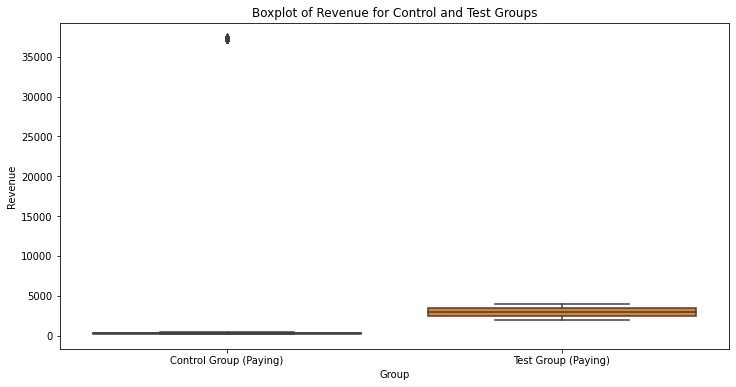

In [131]:
plt.figure(figsize=(12, 6))  
sns.boxplot(data=[control_paying_revenue, test_paying_revenue])
plt.xticks([0, 1], ['Control Group (Paying)', 'Test Group (Paying)']) 
plt.xlabel('Group')
plt.ylabel('Revenue')
plt.title('Boxplot of Revenue for Control and Test Groups')
plt.show()

**Наличие выброса в данных контрольной группы:** это может быть признаком аномальных или крайне высоких значений выручки в группе.

**В тестовой группе наблюдается большее распределение выручки**: более высокий ящик может указывать на более высокую медиану и больший межквартильный размах (IQR) по сравнению с контрольной группой.

### Проверка дисперсий и  нормальности распределений 

Данные большие, поэтому воспользуюсь **Normaltest**.

- $H_0$: Данные распределены нормально.

- $H_1$: Данные распределены ненормально.

In [132]:
print(ss.normaltest(control_paying_revenue))
print(ss.normaltest(test_paying_revenue))

NormaltestResult(statistic=1394.9457843086925, pvalue=1.2341605505935488e-303)
NormaltestResult(statistic=1068.8600084412267, pvalue=7.943249488371762e-233)


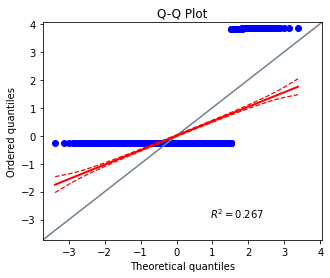

In [133]:
pg.qqplot(control_paying_revenue)

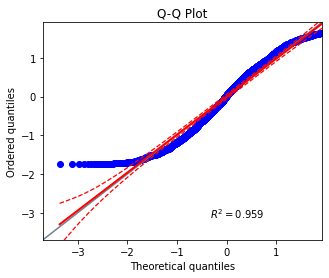

In [134]:
pg.qqplot(test_paying_revenue)

- *p-value* < 0.05 → имеются статистически значимые основания для отклонения нулевой гипотезы.

- Точки на qqplot сильно отклоняются от прямой.

**Вывод**: В ходе неоднократной проверки пришли к выводу, что переменные распределены ненормально.

Также проверим распределения на гомоскедастичность с помощью теста Левена.

In [135]:
pg.homoscedasticity(data=campaign[campaign.revenue > 0], dv="revenue", group="testgroup")

,W,pval,equal_var
levene,80.855674,3.779690e-19,False


**Вывод**: *equal_var* равен False → дисперсии групп не равны. 

Имеем право использовать **t-тест Уэлча**, потому что:

- **Большие выборки:** Центральная предельная теорема (и другие предельные теоремы) делают t-тест устойчивым к нарушению нормальности при больших выборках.

- **Неравенство дисперсий:** Тест на равенство дисперсий показал, что дисперсии между группами не равны. В этом случае корректно использовать тест Уэлча, который не предполагает равенства дисперсий.

In [136]:
# equal_var=False предполагает неравенсвто дисперсий - t-тест Уэлча
ss.ttest_ind(control_paying_revenue, test_paying_revenue, equal_var=False)

Ttest_indResult(statistic=-1.6446302664300838, pvalue=0.10020780398916015)

**Вывод**: *p-value* > 0.05 → нет статистически значимых оснований для отклонения нулевой гипотезы.
Таким образом, средние доходы с платящего пользователя между контрольной и тестовой группами не различаются.

## Заключение

- Конверсия в контрольной группе статистически значимо выше, чем в тестовой
- Показатели ARPU и ARPPU выше в тестовой группе, но это не имеет статистической значимости

В контрольной группе наблюдаются выбросы, и это затрудняет однозначное определение, какое из предложений оказалось более эффективным. Рекомендуется провести дополнительный анализ выбросов, чтобы понять их природу и причины появления в контрольной группе, а также выяснить, почему они отсутствуют в тестовой группе. 

На данный момент не рекомендуется внедрять новые предложения на всю аудиторию.

# Задание 3

В игре *Plants & Gardens* регулярно проводятся тематические события, где игроки могут получить уникальные предметы, бонусы и дополнительные монеты, пройдя ряд уровней за ограниченное время. Оценка эффективности таких событий помогает разработчикам понять, насколько они увлекают игроков, способствуют монетизации и влияют на долгосрочное удержание. Важно использовать корректные метрики, чтобы определить успешность этих событий и внести возможные улучшения.

### Основные метрики для оценки результатов события

1. **Уровень вовлеченности**: Эта метрика показывает, насколько глубоко игроки вовлечены в событие, оценивая, какое количество активных игроков приняло участие в выполнении уровней.

$$
\text{Уровень вовлеченности} = \frac{\text{Число активных участников события}}{\text{Общее число активных игроков}} \times 100\%
$$


2. **Уровень завершения**: Этот показатель отражает процент игроков, завершивших все уровни и получивших награды, и является ключевым индикатором успешности события.

$$
\text{Уровень завершения} = \frac{\text{Число игроков, завершивших событие}}{\text{Число участников события}} \times 100\%
$$


3. **Average Revenue Per User (ARPU)**: ARPU измеряет средний доход, полученный с одного игрока, и помогает понять, насколько событие способствовало общей монетизации игры.

$$
\text{ARPU} = \frac{\text{Общий доход от события}}{\text{Общее число игроков, участвовавших в событии}}
$$


4. **Retention Rate**: Удержание игроков после участия в событии помогает оценить его долгосрочное влияние на активность игроков.

$$
   \text{Retention Rate (Day X)} = \frac{\text{Число игроков, вернувшихся через X дней после участия}}{\text{Число участников события}} \times 100\%
$$

### Метрики при усложнении механики события

1. **Среднее количество попыток на прохождение**: Эта метрика поможет понять, насколько сложнее стало событие для игроков.

$$
\text{Среднее количество попыток на прохождение} = \frac{\text{Общее количество попыток}}{\text{Число игроков, завершивших событие}}
$$


2. **Процент игроков, завершивших событие**: Метрика показывает, сколько игроков смогли преодолеть усложненные уровни и завершить событие.

$$
\text{Процент завершивших} = \frac{\text{Число игроков, завершивших событие}}{\text{Число участников события}} \times 100\%
$$


3. **Процент игроков, покинувших событие**: Эта метрика показывает, сколько игроков прекратили участие в событии из-за его сложности.

$$
\text{Процент покинувших событие} = \frac{\text{Число игроков, покинувших событие до его завершения}}{\text{Число участников события}} \times 100\%
$$


4. **Среднее время прохождения события**: Показывает, сколько времени в среднем потребовалось игрокам, чтобы завершить событие, с учетом новой механики.
$$
\text{Среднее время прохождения} = \frac{\text{Общее время прохождения всех уровней}}{\text{Число игроков, завершивших событие}}
$$
 

Эти метрики помогут оценить, как изменение сложности уровней влияет на поведение, вовлеченность и удовлетворенность игроков, что важно для принятия решений о будущих событиях.